In [1]:
# temp delete after


In [2]:
%matplotlib widget
import sys
from pathlib import Path

# add the root of the project to the path
sys.path.append(str(Path('../').resolve()))

# now we can import the module
from pptt import find_clicks
import mne
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile  # type: ignore
from scipy.signal import stft

from ipyfilechooser import FileChooser


In [3]:
fc = FileChooser('../data/')
fc.filter_pattern = ['*.vhdr']
fc.title = '<b>Select the BrainVision EEG recording containing the photodiode and trigger recordings</b>'
display(fc)

FileChooser(path='G:\github_projects\psychopy-timing-tests\data', filename='', title='<b>Select the BrainVisio…

In [4]:
eeg_data_file = fc.selected

In [6]:
fc2 = FileChooser('../data/')
fc2.filter_pattern = ['*.tsv']
fc2.title = '<b>Select the output timings TSV file from the test</b>'
display(fc2)


FileChooser(path='G:\github_projects\psychopy-timing-tests\data', filename='', title='<b>Select the output tim…

In [12]:
timing_data_file = fc2.selected

In [8]:
fc3 = FileChooser('../data/')
fc3.filter_pattern = ['*.wav']
fc3.title = '<b>Select the audio recording of the test</b>'
display(fc3)

FileChooser(path='G:\github_projects\psychopy-timing-tests\data', filename='', title='<b>Select the audio reco…

In [9]:
mic_recording = fc3.selected

In [10]:
# load brainvision data
raw = mne.io.read_raw_brainvision(eeg_data_file, preload=True)

Extracting parameters from G:\github_projects\psychopy-timing-tests\data\Test_TL.vhdr...
Setting channel info structure...
Reading 0 ... 79579  =      0.000 ...    79.579 secs...


C:\Users\webma\AppData\Local\Temp\ipykernel_20696\3810821807.py:2: RuntimeWarning: No coordinate information found for channels ['AFz', 'F1', 'F5', 'FT7', 'FC3', 'C1']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(eeg_data_file, preload=True)
C:\Users\webma\AppData\Local\Temp\ipykernel_20696\3810821807.py:2: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(eeg_data_file, preload=True)
C:\Users\webma\AppData\Local\Temp\ipykernel_20696\3810821807.py:2: RuntimeWarning: Not setting positions of 8 misc channels found in montage:
['PhotoDiodeDirect', 'Stimtrak', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'C1']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_brainvision(eeg_data_f

In [13]:
# load the timings
timings = pd.read_csv(Path(timing_data_file), sep='\t')  # type: ignore

In [ ]:
# get the clicks in the audio recording
clicks = find_clicks(Path(mic_recording), threshold=0.2, save_data=False)  # type: ignore


In [ ]:
# plot click locations
sr, wav_data = wavfile.read(mic_recording)
# average if stereo
if wav_data.ndim > 1:
    wav_data = np.mean(wav_data, axis=1)

# normalize
wav_data = wav_data / np.max(np.abs(wav_data))

if clicks is None:
    raise ValueError('No clicks found')

click_locations = clicks["timestamp"] * sr
plt.figure(figsize=(20, 10))
plt.plot(np.arange(len(wav_data)), wav_data)
# add clicks as vertical lines
for click in click_locations:
    plt.axvline(click, color='r', linestyle='--')
plt.show()

In [ ]:
# plot as spectrogram
f, t, Zxx = stft(wav_data, fs=sr, nperseg=int(0.01*sr))

plt.figure(figsize=(20, 10))
plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
# add clicks as vertical lines
for click in click_locations:
    plt.axvline(click/sr, color='r', linestyle='--')
plt.show()


In [30]:
# display trigger information from eeg data
photodiode_ch = "PhotoDiodeDirect"
stimtrak_audio_ch = "Stimtrak"

# get segments names from the raw data
segments = set(raw.annotations.description)

eeg_picks = mne.pick_channels(raw.ch_names, [photodiode_ch, stimtrak_audio_ch])


In [90]:
segment_prefx = 'Response/R'
bit_friendly_names = [
    'Photodiode',
    'Mouse Click',
    'Audio Beep',
    'N/A',
    'N/A',
    'N/A',
    'N/A',
    'N/A',
]
segment_pin_map = {}
segment_event_map = {}
event_segment_map = {}
pin_count = 8
for segment in segments:
    if segment.startswith(segment_prefx):
        pin_states = []
        value = int(segment.split(" ")[-1])
        friendly_name = ''
        segment_event_map[segment] = value
        for pin in range(1, pin_count + 1):
            # bit flags
            pin_state = (value & (1 << pin)) >> pin
            pin_states.append(pin_state)
            if pin_state:
                friendly_name += bit_friendly_names[pin-1] + ' + '
        if friendly_name:
            friendly_name = friendly_name[:-3]
            event_segment_map[value] = friendly_name
        segment_pin_map[segment] = pin_states

# event_segment_map = {v: k for k, v in segment_event_map.items()}

segment_pin_map, segment_event_map, event_segment_map

({'Response/R 10': [1, 0, 1, 0, 0, 0, 0, 0],
  'Response/R  4': [0, 1, 0, 0, 0, 0, 0, 0],
  'Response/R  2': [1, 0, 0, 0, 0, 0, 0, 0],
  'Response/R  8': [0, 0, 1, 0, 0, 0, 0, 0],
  'Response/R  6': [1, 1, 0, 0, 0, 0, 0, 0]},
 {'Response/R 10': 10,
  'Response/R  4': 4,
  'Response/R  2': 2,
  'Response/R  8': 8,
  'Response/R  6': 6},
 {10: 'Photodiode + Audio Beep',
  4: 'Mouse Click',
  2: 'Photodiode',
  8: 'Audio Beep',
  6: 'Photodiode + Mouse Click'})

In [88]:
events = mne.events_from_annotations(raw, event_id=segment_event_map)


Used Annotations descriptions: ['Response/R  2', 'Response/R  4', 'Response/R  6', 'Response/R  8', 'Response/R 10']


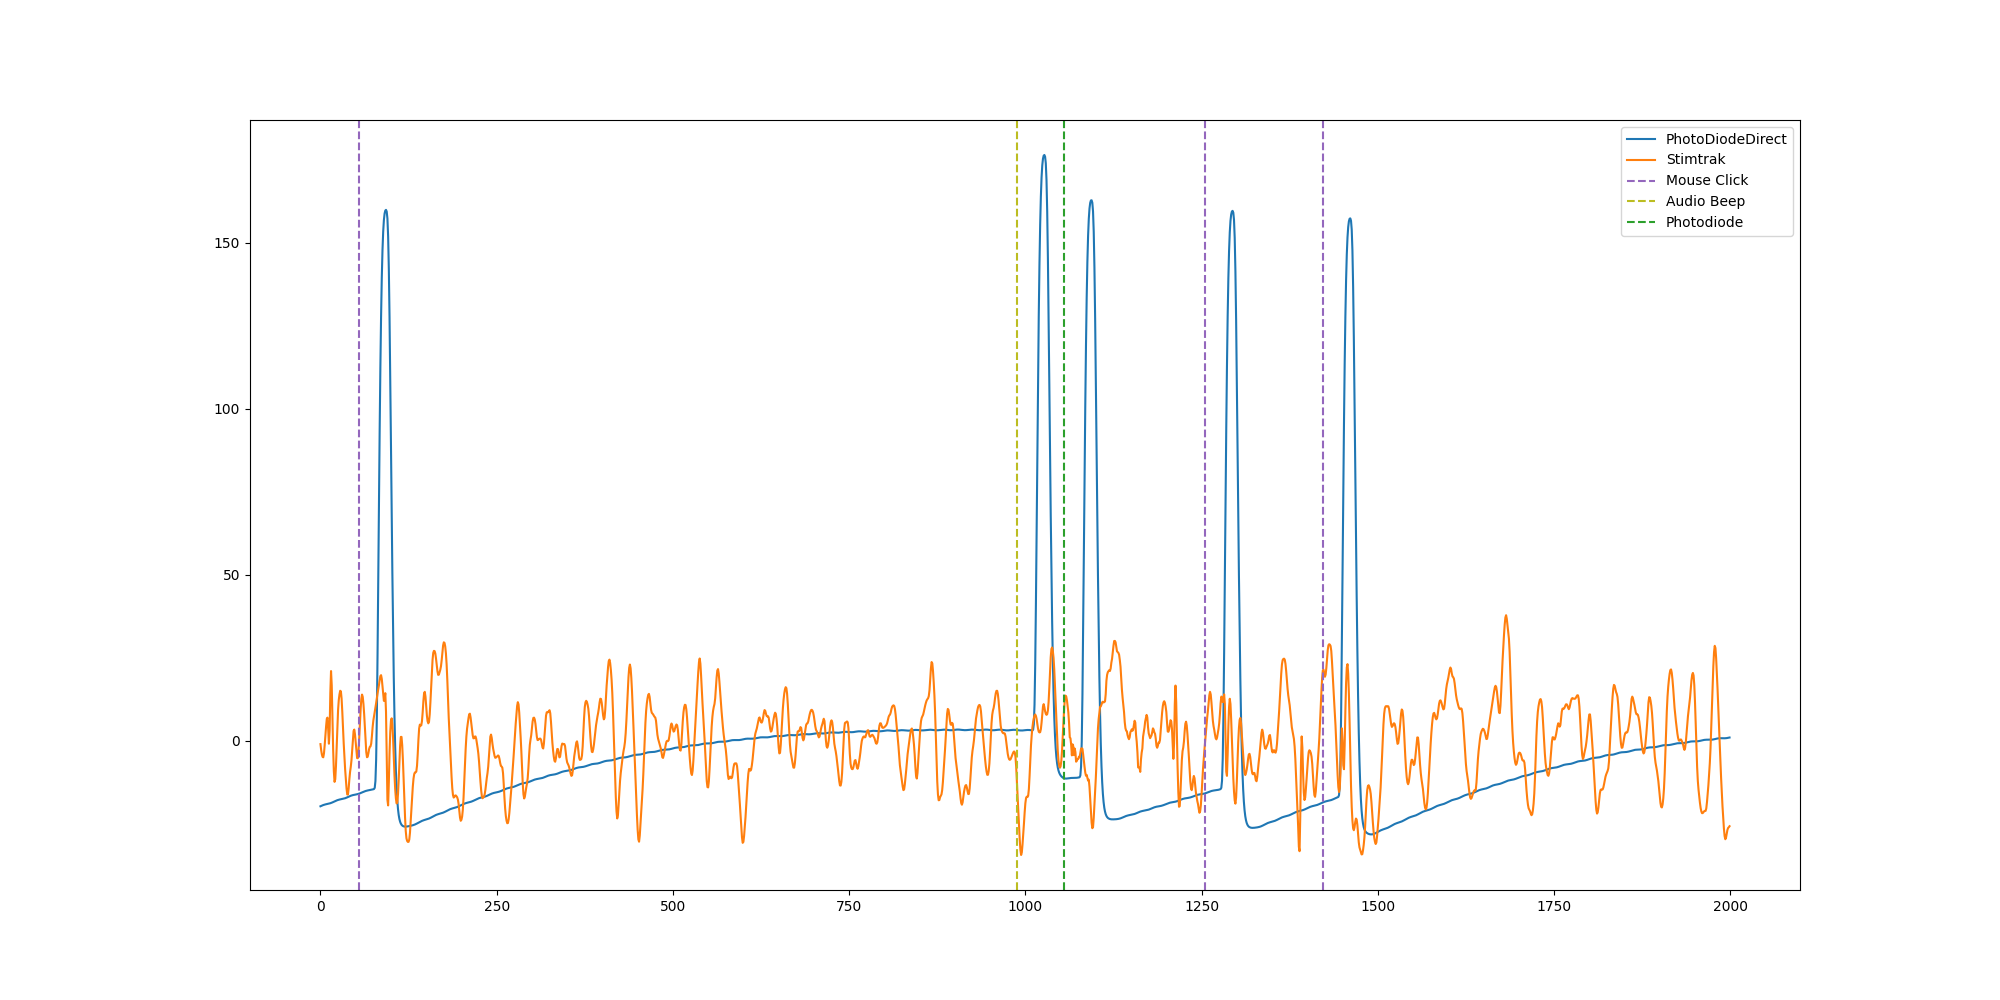

In [92]:
# get the photodiode and audio trigger data
photodiode_data = raw.get_data([eeg_picks[0]])
stimtrak_audio_data  = raw.get_data([eeg_picks[1]])

triggers = events[0]


photodiode_data = np.squeeze(photodiode_data)
stimtrak_audio_data = np.squeeze(stimtrak_audio_data)
# plot 1 second of data somewhere in the middle
# get the middle of the recording
middle = len(photodiode_data) // 2
length = raw.info['sfreq']*2

plt.figure(figsize=(20, 10))
plt.plot(photodiode_data[middle:int(middle+length)], label=photodiode_ch)
plt.plot(stimtrak_audio_data[middle:int(middle+length)], label=stimtrak_audio_ch)
# add triggers
for trigger in triggers:
    if trigger[0] > middle and trigger[0] < middle+length:
        # color based on the event
        plt.axvline(trigger[0] - middle, linestyle='--', label=event_segment_map[trigger[2]], color=f'C{trigger[2]}')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()


array([ 0.   ,  9.083,  9.654, 10.154, 10.754, 11.071, 11.588, 12.422,
       13.056, 13.807, 14.09 , 14.123, 15.041, 15.758, 15.842, 16.159,
       16.359, 17.026, 17.376, 17.426, 19.011, 19.094, 19.695, 19.911,
       20.079, 20.412, 20.762, 20.996, 22.43 , 22.964, 22.981, 22.997,
       23.782, 24.099, 24.332, 24.966, 25.165, 25.333, 25.767, 26.951,
       27.435, 27.901, 28.936, 29.103, 29.786, 29.952, 30.103, 30.587,
       30.77 , 30.921, 32.438, 32.905, 33.255, 34.106, 34.89 , 35.207,
       35.374, 35.774, 36.875, 37.442, 37.743, 38.859, 39.11 , 39.51 ,
       39.678, 39.844, 40.778, 40.845, 41.045, 41.212, 42.447, 42.83 ,
       42.997, 43.18 , 44.115, 44.815, 45.366, 45.532, 45.699, 45.782,
       46.799, 47.45 , 47.617, 48.034, 48.785, 49.119, 50.77 , 50.786,
       50.803, 51.254, 51.704, 51.887, 52.455, 52.754, 53.606, 53.839,
       54.122, 54.74 , 55.224, 55.407, 55.574, 55.791, 56.725, 57.458,
       58.71 , 59.127, 59.243, 59.41 , 59.61 , 60.695, 60.794, 62.463,
      